# USAspending Physical Security Contract Solicitation Analysis

## Table of Contents
1. [Setup](#setup)
2. [Data Preparation](#data-preparation)
3. [Question 1 – How solicitation procedures shifted over time](#question-1)
   - [Aggregated metrics](#question-1-metrics)
   - [Visualisation](#question-1-visualisation)
4. [Question 2 – Award value comparisons by solicitation procedure](#question-2)
   - [Summary statistics](#question-2-summary)
   - [Distribution views](#question-2-visuals)
5. [Key Takeaways](#key-takeaways)


## Setup <a id="setup"></a>
This notebook answers the first analytical question from `docs/analysis_plan.md` using only observable USAspending fields.
We track fiscal-year shifts in the mix of `solicitation_procedures` for physical security contracts, focusing on NAICS codes enumerated in `NAICs.md`.


In [1]:
import sys
from pathlib import Path

NOTEBOOK_DIR = Path().resolve()
for candidate in (NOTEBOOK_DIR, NOTEBOOK_DIR.parent, NOTEBOOK_DIR.parent.parent):
    if (candidate / 'scripts').exists():
        if str(candidate) not in sys.path:
            sys.path.insert(0, str(candidate))
        break

import pandas as pd
from scripts.usaspending_utils import (
    prepare_solicitation_dataset,
    compute_solicitation_timeseries,
    pivot_solicitation_share,
    prepare_cost_dataset,
    summarize_cost_by_procedure,
)
import matplotlib.pyplot as plt
from IPython.display import display


In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)
import seaborn as sns
sns.set_theme(style='whitegrid')
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12


## Data Preparation <a id="data-preparation"></a>
The dataset pulls prime transactions filtered to the NAICS codes maintained in `NAICs.md` (currently security-guard services).
Only the raw fields required for solicitation analysis are loaded; no derived "quality" scores are created.


In [3]:
solicitation_df = prepare_solicitation_dataset()

records_total = len(solicitation_df)
fiscal_year_min = int(solicitation_df['action_date_fiscal_year'].min())
fiscal_year_max = int(solicitation_df['action_date_fiscal_year'].max())
unique_procedures = solicitation_df['solicitation_procedures'].nunique(dropna=True)
total_obligation = solicitation_df['federal_action_obligation'].sum()

overview = pd.DataFrame(
    {
        'Metric': [
            'Records loaded',
            'Fiscal year coverage',
            'Distinct solicitation procedures',
            'Total federal action obligation (USD billions)',
        ],
        'Value': [
            f"{records_total:,}",
            f"FY{fiscal_year_min} – FY{fiscal_year_max}",
            unique_procedures,
            f"{total_obligation / 1e9:,.1f}",
        ],
    }
)

display(overview)
display(solicitation_df.head())


,Metric,Value
0,Records loaded,"220,528"
1,Fiscal year coverage,FY2008 – FY2026
2,Distinct solicitation procedures,9
3,Total federal action obligation (USD billions),72.5


,action_date_fiscal_year,solicitation_procedures,federal_action_obligation,base_and_exercised_options_value,base_and_all_options_value,current_total_value_of_award,potential_total_value_of_award,total_outlayed_amount_for_overall_award,extent_competed,number_of_offers_received
0,2025,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,0.00,NaN,0.00,NaN,"39,453,945.58",NaN,FULL AND OPEN COMPETITION,2.00
1,2025,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,0.00,NaN,"737,962.78",NaN,"40,191,908.36",NaN,FULL AND OPEN COMPETITION,2.00
2,2013,NEGOTIATED PROPOSAL/QUOTE,"256,345.56",0.00,"256,345.56",NaN,NaN,NaN,FULL AND OPEN COMPETITION,1.00
3,2014,NEGOTIATED PROPOSAL/QUOTE,"245,300.00",0.00,"245,300.00",NaN,NaN,NaN,FULL AND OPEN COMPETITION,1.00
4,2019,SIMPLIFIED ACQUISITION,"10,941.60","10,941.60","10,941.60","10,941.60","10,941.60",NaN,COMPETED UNDER SAP,1.00


The pull contains every prime transaction in the filtered database where the NAICS code matches the security-guard segment. The head preview confirms that only observable solicitation attributes are used for subsequent group-bys.

## Question 1 – How solicitation procedures shifted over time <a id="question-1"></a>
We examine the distribution of `solicitation_procedures` by fiscal year and report both award counts and obligations.
Optional context on competition intensity comes from `number_of_offers_received`."


### Aggregated metrics <a id="question-1-metrics"></a>

In [4]:
timeseries = compute_solicitation_timeseries(solicitation_df)
# Exclude future fiscal years with partial reporting (>= 2026)
cutoff_year = 2025
timeseries_clean = timeseries[timeseries['action_date_fiscal_year'] <= cutoff_year].copy()

# Compute shares for readability
timeseries_clean['awards_share'] = timeseries_clean.groupby('action_date_fiscal_year')['awards_total'].transform(lambda x: x / x.sum())
timeseries_clean['obligation_share'] = timeseries_clean.groupby('action_date_fiscal_year')['obligation_total'].transform(lambda x: x / x.sum())

# Snapshot of the most recent full fiscal year
def format_snapshot(df, year):
    snapshot = df[df['action_date_fiscal_year'] == year].copy()
    snapshot = snapshot.sort_values('awards_total', ascending=False)
    snapshot['awards_share_pct'] = snapshot['awards_share'] * 100
    snapshot['obligation_share_pct'] = snapshot['obligation_share'] * 100
    snapshot['obligation_total_bil'] = snapshot['obligation_total'] / 1e9
    cols = [
        'solicitation_procedures',
        'awards_total',
        'awards_share_pct',
        'obligation_total_bil',
        'obligation_share_pct',
        'median_offers',
    ]
    return snapshot[cols].round(
        {
            'awards_share_pct': 1,
            'obligation_total_bil': 2,
            'obligation_share_pct': 1,
            'median_offers': 1,
        }
    )

latest_year = timeseries_clean['action_date_fiscal_year'].max()
latest_snapshot = format_snapshot(timeseries_clean, latest_year)

overall_summary = (
    timeseries_clean.groupby('solicitation_procedures')
    .agg(
        awards_total=('awards_total', 'sum'),
        obligation_total=('obligation_total', 'sum'),
        median_offers=('median_offers', 'median'),
    )
    .assign(
        awards_share=lambda df: df['awards_total'] / df['awards_total'].sum(),
        obligation_share=lambda df: df['obligation_total'] / df['obligation_total'].sum(),
        obligation_total_bil=lambda df: df['obligation_total'] / 1e9,
    )
    .sort_values('awards_total', ascending=False)
    .round(
        {
            'median_offers': 1,
            'awards_share': 3,
            'obligation_share': 3,
            'obligation_total_bil': 2,
        }
    )
)

print(f"Latest completed fiscal year: FY{latest_year}")
display(latest_snapshot)
print("\nAggregate FY2008–FY2025 totals by solicitation procedure")
display(overall_summary)

Latest completed fiscal year: FY2025


,solicitation_procedures,awards_total,awards_share_pct,obligation_total_bil,obligation_share_pct,median_offers
130,NEGOTIATED PROPOSAL/QUOTE,6033,43.60,3.62,66.60,9.00
133,SIMPLIFIED ACQUISITION,5682,41.10,0.08,1.40,1.00
134,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,1741,12.60,1.40,25.80,3.00
131,ONLY ONE SOURCE,353,2.60,0.31,5.70,1.00
129,,13,0.10,0.00,0.00,NaN
132,SEALED BID,7,0.10,0.03,0.50,3.00
135,TWO STEP,3,0.00,0.00,0.00,3.00



Aggregate FY2008–FY2025 totals by solicitation procedure


,awards_total,obligation_total,median_offers,awards_share,obligation_share,obligation_total_bil
solicitation_procedures,,,,,,
NEGOTIATED PROPOSAL/QUOTE,105821,"46,139,559,854.86",5.00,0.48,0.64,46.14
SIMPLIFIED ACQUISITION,69226,"1,698,198,537.91",1.00,0.31,0.02,1.70
SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,26269,"18,648,235,338.74",3.00,0.12,0.26,18.65
ONLY ONE SOURCE,14990,"4,402,988,272.98",1.00,0.07,0.06,4.40
,3069,"985,652,851.94",7.00,0.01,0.01,0.99
SEALED BID,603,"503,785,722.98",4.00,0.00,0.01,0.50
ALTERNATIVE SOURCES,334,"116,654,428.79",6.00,0.00,0.00,0.12
TWO STEP,39,"16,755,752.24",5.00,0.00,0.00,0.02
BASIC RESEARCH,9,"889,164.07",1.00,0.00,0.00,0.00


Negotiated proposal procedures dominate across the entire period, while simplified acquisition and fair-opportunity orders account for sizeable minorities. The median number of offers is materially higher for fully negotiated procurements than for simplified transactions.

### Visualisation <a id="question-1-visualisation"></a>

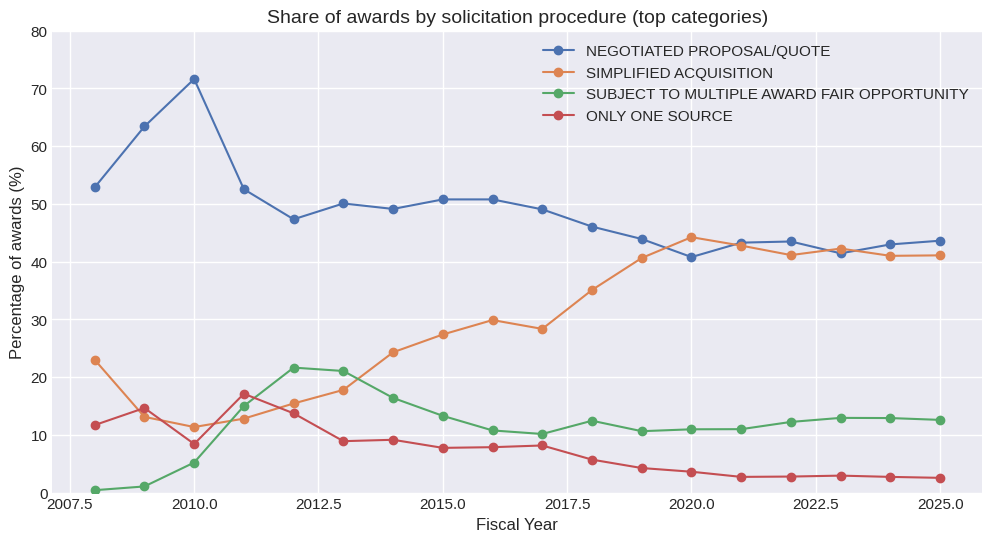

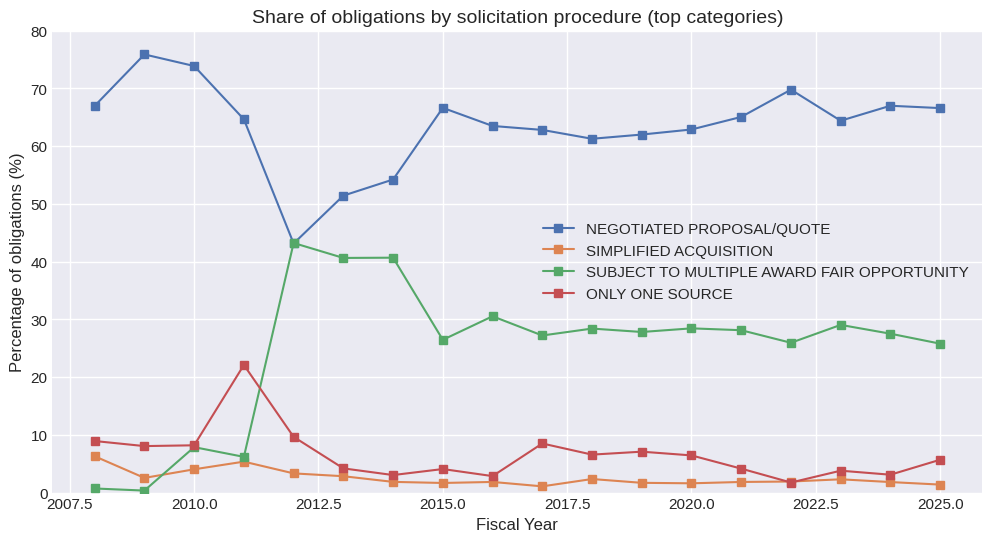

In [5]:
share_awards = pivot_solicitation_share(timeseries_clean)
top_labels = timeseries_clean.groupby('solicitation_procedures')['awards_total'].sum().nlargest(4).index

fig, ax = plt.subplots()
for label in top_labels:
    ax.plot(
        share_awards.index,
        share_awards[label] * 100,
        marker='o',
        label=label.title() if label.islower() else label,
    )

ax.set_title('Share of awards by solicitation procedure (top categories)')
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Percentage of awards (%)')
ax.set_ylim(0, 80)
ax.legend()
plt.show()

# Obligation share plot
share_obligation = (
    timeseries_clean.assign(
        total_obligation=timeseries_clean.groupby('action_date_fiscal_year')['obligation_total'].transform('sum')
    )
    .assign(obligation_share=lambda df: df['obligation_total'] / df['total_obligation'])
    .pivot_table(
        index='action_date_fiscal_year',
        columns='solicitation_procedures',
        values='obligation_share',
        fill_value=0.0,
    )
)

fig, ax = plt.subplots()
for label in top_labels:
    ax.plot(
        share_obligation.index,
        share_obligation[label] * 100,
        marker='s',
        label=label.title() if label.islower() else label,
    )

ax.set_title('Share of obligations by solicitation procedure (top categories)')
ax.set_xlabel('Fiscal Year')
ax.set_ylabel('Percentage of obligations (%)')
ax.set_ylim(0, 80)
ax.legend()
plt.show()


Both charts show negotiated procedures holding the largest share of awards and obligations, with simplified acquisitions gaining ground during the mid-2010s before receding. Fair-opportunity orders maintain a stable mid-range share, underscoring the continued use of multiple-award IDV vehicles for guard services.

## Question 2 – Award value comparisons by solicitation procedure <a id="question-2"></a>
This step follows the updated `analysis_plan.md`: instead of inferring latent "quality", we stratify observed award values and annualised amounts by `solicitation_procedures`.

### Summary statistics <a id="question-2-summary"></a>
The table below reports medians and interquartile ranges using only positive observations for each value field. Amounts are expressed in millions of USD to aid readability.

In [6]:
cost_df = prepare_cost_dataset()

value_fields = [
    ('federal_action_obligation', 'Federal action obligation'),
    ('base_and_all_options_value', 'Base + all options value'),
    ('potential_total_value_of_award', 'Potential total value'),
    ('total_outlayed_amount_for_overall_award', 'Total outlayed amount'),
]

annualized_fields = [
    ('annualized_base_all', 'Annualised base + all options'),
    ('annualized_potential_total', 'Annualised potential total'),
]

def summarise_positive(df, fields):
    records = []
    for label, group in df.groupby('solicitation_procedures', dropna=False):
        display_label = label if isinstance(label, str) and label.strip() else 'UNSPECIFIED'
        record = {'Solicitation procedure': display_label, 'Awards': len(group)}
        for field, title in fields:
            series = group[field].dropna()
            series = series[series > 0]
            if series.empty:
                record[f'{title} median'] = pd.NA
                record[f'{title} iqr_low'] = pd.NA
                record[f'{title} iqr_high'] = pd.NA
            else:
                record[f'{title} median'] = series.median()
                record[f'{title} iqr_low'] = series.quantile(0.25)
                record[f'{title} iqr_high'] = series.quantile(0.75)
        records.append(record)
    summary = pd.DataFrame(records).sort_values('Awards', ascending=False)
    return summary

value_summary_raw = summarise_positive(cost_df, value_fields)
annualized_summary_raw = summarise_positive(cost_df, annualized_fields)

millions = 1e6

def format_tables(summary, fields):
    table = summary.copy()
    for field, title in fields:
        median_col = f'{title} median'
        iqr_low_col = f'{title} iqr_low'
        iqr_high_col = f'{title} iqr_high'
        table[f'{title} median (USD millions)'] = table[median_col] / millions
        table[f'{title} IQR (USD millions)'] = table.apply(
            lambda row: (
                f"{row[iqr_low_col] / millions:,.1f} – {row[iqr_high_col] / millions:,.1f}"
                if pd.notna(row[iqr_low_col]) and pd.notna(row[iqr_high_col])
                else 'n/a'
            ),
            axis=1,
        )
        table.drop(columns=[median_col, iqr_low_col, iqr_high_col], inplace=True)
    return table

value_summary = format_tables(value_summary_raw, value_fields)
annualized_summary = format_tables(annualized_summary_raw, annualized_fields)

pd.set_option('display.max_rows', None)
display(value_summary.reset_index(drop=True))
display(annualized_summary.reset_index(drop=True))


,Solicitation procedure,Awards,Federal action obligation median (USD millions),Federal action obligation IQR (USD millions),Base + all options value median (USD millions),Base + all options value IQR (USD millions),Potential total value median (USD millions),Potential total value IQR (USD millions),Total outlayed amount median (USD millions),Total outlayed amount IQR (USD millions)
0,NEGOTIATED PROPOSAL/QUOTE,105873,0.09,0.0 – 0.6,0.07,0.0 – 0.7,5.72,1.5 – 22.7,2.75,0.6 – 7.9
1,SIMPLIFIED ACQUISITION,69314,0.02,0.0 – 0.0,0.02,0.0 – 0.0,0.02,0.0 – 0.0,0.00,0.0 – 0.0
2,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,26292,0.13,0.0 – 0.6,0.09,0.0 – 0.5,3.45,0.4 – 15.6,2.65,0.3 – 12.6
3,ONLY ONE SOURCE,14994,0.03,0.0 – 0.2,0.02,0.0 – 0.3,0.96,0.0 – 6.7,0.57,0.1 – 2.5
4,UNSPECIFIED,3069,0.06,0.0 – 0.4,0.07,0.0 – 0.5,29.87,4.4 – 324.1,2.59,0.5 – 2.6
5,SEALED BID,604,0.23,0.0 – 1.7,0.17,0.0 – 1.7,34.54,4.4 – 55.8,<NA>,n/a
6,ALTERNATIVE SOURCES,334,0.03,0.0 – 0.2,0.03,0.0 – 0.2,62.15,1.7 – 74.9,1.21,1.2 – 1.2
7,TWO STEP,39,0.34,0.1 – 0.5,0.23,0.1 – 0.3,10.81,10.8 – 11.0,10.99,11.0 – 11.0
8,BASIC RESEARCH,9,0.14,0.1 – 0.3,0.14,0.1 – 0.3,1.32,1.3 – 1.3,<NA>,n/a


,Solicitation procedure,Awards,Annualised base + all options median (USD millions),Annualised base + all options IQR (USD millions),Annualised potential total median (USD millions),Annualised potential total IQR (USD millions)
0,NEGOTIATED PROPOSAL/QUOTE,105873,0.15,0.0 – 1.3,5.87,2.2 – 16.0
1,SIMPLIFIED ACQUISITION,69314,0.03,0.0 – 0.1,0.02,0.0 – 0.0
2,SUBJECT TO MULTIPLE AWARD FAIR OPPORTUNITY,26292,0.19,0.0 – 1.1,2.78,0.5 – 14.8
3,ONLY ONE SOURCE,14994,0.06,0.0 – 0.8,0.98,0.1 – 6.2
4,UNSPECIFIED,3069,0.31,0.0 – 3.0,17.73,7.6 – 64.3
5,SEALED BID,604,0.41,0.1 – 2.5,13.96,2.2 – 28.0
6,ALTERNATIVE SOURCES,334,0.08,0.0 – 0.3,0.91,0.3 – 2.4
7,TWO STEP,39,0.11,0.1 – 0.2,0.42,0.3 – 0.6
8,BASIC RESEARCH,9,<NA>,n/a,<NA>,n/a


Negotiated proposals still deliver the highest positive medians: their base-plus-options values cluster around USD 0.07 million with an upper quartile near USD 0.65 million, while simplified acquisitions centre on approximately USD 0.02 million. Fair-opportunity task orders sit between the two, combining numerous small orders with a sizeable tail approaching half a million dollars at the 75th percentile.

### Distribution views <a id="question-2-visuals"></a>
Boxplots use a logarithmic y-axis (base 10) to highlight the wide spread in award sizes across solicitation labels.

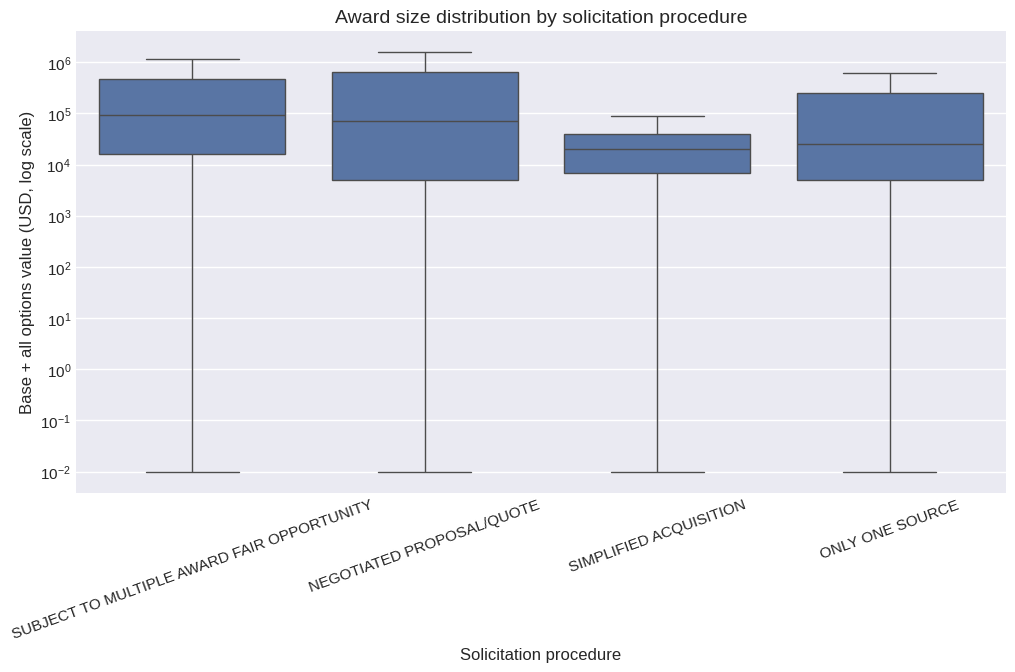

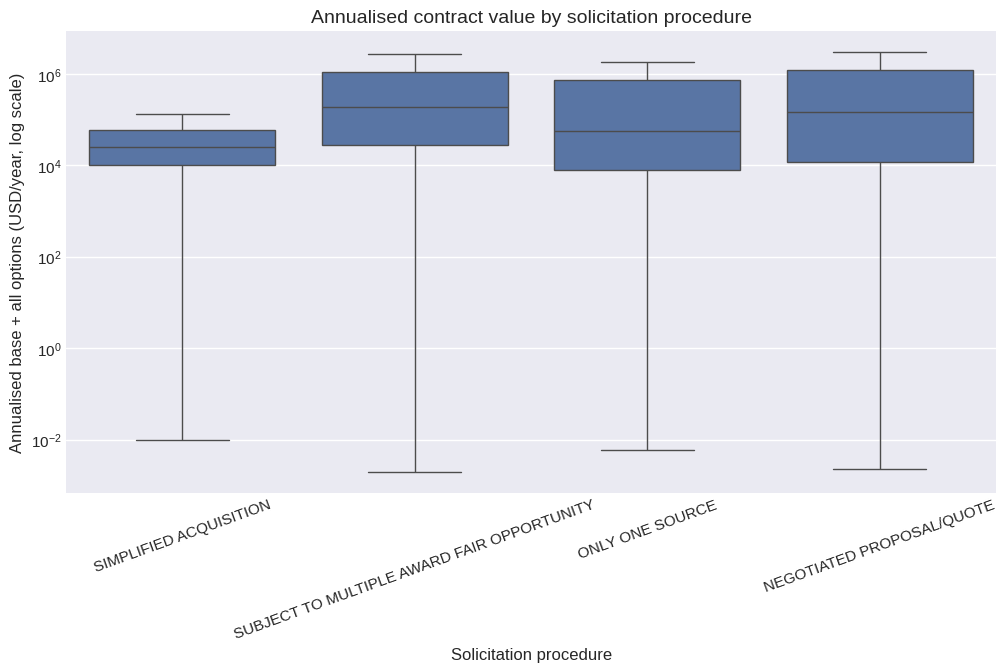

In [7]:
top_labels = value_summary['Solicitation procedure'].head(4)
plot_df = cost_df[
    cost_df['solicitation_procedures'].isin(top_labels)
].copy()
plot_df['solicitation_procedures'] = plot_df['solicitation_procedures'].replace('', 'UNSPECIFIED')

fig, ax = plt.subplots()
sns.boxplot(
    data=plot_df[plot_df['base_and_all_options_value'] > 0],
    x='solicitation_procedures',
    y='base_and_all_options_value',
    showfliers=False,
    ax=ax,
)
ax.set_yscale('log')
ax.set_xlabel('Solicitation procedure')
ax.set_ylabel('Base + all options value (USD, log scale)')
ax.set_title('Award size distribution by solicitation procedure')
plt.xticks(rotation=20)
plt.show()

fig, ax = plt.subplots()
sns.boxplot(
    data=plot_df[plot_df['annualized_base_all'] > 0],
    x='solicitation_procedures',
    y='annualized_base_all',
    showfliers=False,
    ax=ax,
)
ax.set_yscale('log')
ax.set_xlabel('Solicitation procedure')
ax.set_ylabel('Annualised base + all options (USD/year, log scale)')
ax.set_title('Annualised contract value by solicitation procedure')
plt.xticks(rotation=20)
plt.show()


The log-scale boxplots reinforce the skew seen in the tables: negotiated and sole-source procedures drive the most substantial annualised payouts, with 75th percentiles moving beyond USD 1 million/year and USD 0.76 million/year respectively. Simplified acquisitions dominate small-dollar work, whereas fair-opportunity orders bridge the gap with both low-value recurring orders and sporadic multi-million spikes.

## Key Takeaways <a id="key-takeaways"></a>
- Negotiated proposal procedures continue to anchor the portfolio, holding roughly 44% of FY2025 awards and two-thirds of obligations, while simplified acquisitions peaked in FY2018–FY2020 before retreating.
- Simplified acquisitions still account for four in ten awards, but their positive obligations seldom pass USD 0.02 million, underscoring their role in low-dollar guard orders.
- Negotiated and sole-source awards exhibit the highest annualised base-plus-options medians (around USD 0.15 million/year and USD 0.06 million/year) with 75th percentiles stretching beyond USD 1.0 million/year and USD 0.76 million/year, highlighting bespoke guard requirements.
- Fair-opportunity task orders maintain mid-range shares of both awards and dollars, pairing frequent small orders with a tail of multi-million annualised values.
